# 2D Layer Surface Segmentation 

**Add Proper References Here**

Load essential modules for loading and showing data

In [1]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread 

In [2]:
# Load image
in_dir = 'data/'
data = imread(in_dir+'layer2D.png').astype(np.int32)

# Show image.
plt.imshow(data, cmap='gray')
plt.show()

## Detect one layer

In [3]:
from slgbuilder import GraphObject,MaxflowBuilder

Let's create an object that represent the layer we're trying a segment. Here we are only segmenting one layer. The image data is passed directly to the ```GraphObject```. By default, it assumes data is structured on a regular index grid.

The algorithm segments layers by detecting dark lines. For better segmentation the image is inversed by `255-data`.

In [4]:
layer_1 = GraphObject(255-data)

Next we create the ```MaxflowBuilder``` and add the layer. Then we add layered cost and smoothness. Edges are added automatically for when calling ```add_layered_boundary_cost``` and ```add_layered_smoothness```. By default these edges are added for all object previously added to the ```GraphHelper```. However, it is possible to add the edges for specific object only, by passing a list of objects to the function. The graph structure is based on [Li et al](https://doi.org/10.1109/TPAMI.2006.19).

In [5]:
helper = MaxflowBuilder()
helper.add_object(layer_1)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness()

The graph is cut using the [Maxflow](https://github.com/Skielex/maxflow) algorithm to get the maximum flow/minimum cut. This algorithm will find the global optimal solution to the binary segmentation problem. 

In [6]:
flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 86761


The segmentation for ```layer_1``` can then be displayed.

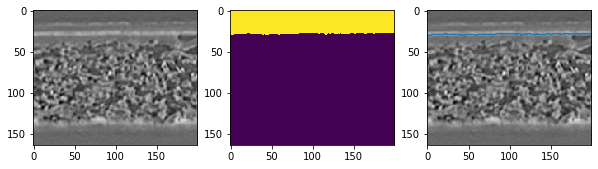

In [7]:
segmentation = helper.what_segments(layer_1)
segmentation_line = np.argmin(segmentation, axis=0)

# Draw results.
f,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(data, cmap='gray')
ax[1].imshow(segmentation)
ax[2].imshow(data, cmap='gray')
ax[2].plot(segmentation_line)
plt.show()

## Detect multiple layers

This time we will create two objects, as we want to segment two different layers. Although our graph cut is still binary, we will create the graph so that we get a multi-label segmentation.

In [8]:
layers = []
for i in range(2):
    layers.append(GraphObject(255-data))

We create the ```MaxflowBuilder``` and add all layers to the graph. We then add boundary costs and smoothness as before.

In [9]:
helper = MaxflowBuilder()
helper.add_objects(layers)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness()

We've added the layers to the graph, but because they all are based on the same data, and there are no interaction contraints between the layers, they would all result in the exact same segmentation. This is *not* what we want.
We want the layers to be separated by a certain distance. Luckily [Li et al](https://doi.org/10.1109/TPAMI.2006.19). describe how to enforce a minimum distance between the layers. This technique has been implemented in ```add_layered_containment```, which takes an *outer* and an *inner* ```GraphObject``` and lets you specify both a minimum and maximum distance/margin between them. In this case we will only specify a minimum margin.

In [10]:
for i in range(len(layers)-1):
    helper.add_layered_containment(layers[i], layers[i+1], min_margin=10)

In [11]:
flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 174018


We can now get the segmentations for all layers and show them. Notice that the blue line, representing the first layers is the furthest down, or outermost.

In [12]:
segmentations = [helper.what_segments(l).astype(np.int32) for l in layers]
segmentation_lines = [np.argmin(s, axis=0) - 0.5 for s in segmentations]

# Draw results.
f,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(data, cmap='gray')
ax[1].imshow(np.sum(segmentations, axis=0))
ax[2].imshow(data, cmap='gray')
for line in segmentation_lines:
    ax[2].plot(line)
plt.show()